# Práctica 3 

Git-hub con el código : https://github.com/MarcBalle/MUSI/tree/main/Vision

# Single view geometry & Epipolar lines

Esta tercera práctica se divide en dos ejercicios diferentes. Por un lado, se trata de obtener la altura de una persona en una sola imagen y, por otro lado, se pretende obtener la matriz fundamental de un sistema estéreo (dos imágenes) y dibujar las líneas epipolares correspondientes a puntos coincidentes en ambas imágenes. 

## Single view geometry

Como ya se ha comentado, en este primer ejercicio se va a proceder a calcular la altura de una persona haciendo uso de la siguiente expresión: 

$\alpha Z = \frac{||b \times t||}{(l \cdot b)||V_z \times t||}$

Donde:
 - $\alpha$ corresponde aun factor de escala en el plano Z en el cual se buscará la altura deseada
 - $Z$ corresponde con la altura buscada
 - $b$ es la base del objeto o persona sobre el cual se está midiendo su altura
 - $t$ es la parte superior del objeto o persona sobre el cual se está midiendo su altura
 - $l$ corresponde con la linea de horizonte
 - $V_z$ es el punto de fuga en el plano Z

Primero de todo se importan aquellas librerías necesarias para el desarrollo del programa. En este caso se hace uso de la función Tuple de la libreria _typing_ , la cual permite crear una tupla de elementos de un determinada clase cada uno. 

De la librería _numpy_ se va a hacer uso principalmente de las funciones _cross_ y _norm_ , las cuales permiten calcular el producto vectorial entre dos vectores y la norma de un vector, respectivamente.

In [77]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
from typing import Tuple  

A continuación se definen una serie de funciones imprescindibles para el correcto fucnionamiento del código. Primero de todo se inicializan dos variables que servirán como referencia para evaluar si se quiere transformas de coordenadas originales (las de la imagen, 2D) a homogéneas o viceversa

In [78]:
ORG_2_HMG = 1
HMG_2_ORG = 2

En este punto se define la función _convert_, que nos permitirá la transformación de coordenadas previamente mencionada. Esta transformación es necesaria ya que durante buena parte del proceso se va a estar trabajando en el espacio proyectivo. 

In [79]:
def convert(coordinates, img: np.ndarray, code: int):
    if code != ORG_2_HMG and code != HMG_2_ORG:
        raise TypeError("Unknown operation")
        
    if code == ORG_2_HMG:
        return __to_homogenous(coordinates, (img.shape[1], img.shape[0]))
    
    elif code == HMG_2_ORG:
        return __to_original(coordinates, (img.shape[1], img.shape[0]))

Función que convierte coordenadas imagen a coordenadas homogéneas. En este caso la coordenada $w$, la cual puede interpretarse como un factor de escala, se define como un cuarto de la suma del ancho y alto de la imagen. Muchas veces únicamente se iguala a 1. 

In [80]:
def __to_homogenous(coordinates: Tuple[int, int], size: Tuple[int, int]):
    
    semi_axis = np.array(size) / 2

    w = ((size[0] + size[1]) / 4)

    homogenous = np.array([coordinates[0] - semi_axis[0], coordinates[1] - semi_axis[1]])
    homogenous = np.append(homogenous, [w])

    return tuple(homogenous)

Función que convierte de coordenadas homogéneas a coordenadas imagen. 

In [81]:
def __to_original(coordinates: Tuple[int, int], size: Tuple[int, int]):
    semi_axis = np.array(size) / 2

    w = ((size[0] + size[1]) / 4)

    original_x = int(((coordinates[0] / coordinates[-1]) * w) + semi_axis[1])
    original_y = int(((coordinates[1] / coordinates[-1]) * w) + semi_axis[0])

    return original_x, original_y

In [82]:
im = cv2.imread('./in/passadis.jpg')

### Obtención del parámetro $\alpha$

Primero de todo debe obtenerse el valor del parámetro $\alpha$ especificado al principio. Para ello debe procederse con un objeto o persona de la escena del cual se conozca de antemano su altura. En este caso se selecciona la puerta con una altura de 202 cm. 

Una vez dicho esto, se definen las coordenadas de los puntos necesarios haciendo uso de la función interactiva empleada en la primera práctica de las homografías. 

Los dos primeros puntos corresponden con la parte inferior y superior de la puerta que definen la altura de 202 cm. Los siguientes puntos corresponden a puntos situados sobre líneas paralelas encontradas en la escena. Esto es necesario ya que para calcular la linea de horizonte (necesaria para el cálculo de la altura) se necesitan dos puntos de fuga en el plano XY (plano tierra). Para calcular dichos puntos de fuga se requiere a su vez calcular la intersección entre (al menos) dos rectas paralelas pertenecientes al plano XY. Finalmente el cálculo de dichas rectas pasa por la selección de dos puntos pertenecientes a cada recta. En resumen, un punto de fuga viene definido por la siguiente expresión: 

$V = (p_1 \times p_2) \times (p_3 \times p_4)$

Donde cada recta de determina por el producto escalar de dos de sus puntos y el punto de fuga se calcula como la intersección de dos rectas definida por el producto escalar de dichas rectas. Todo esto hablando dentro del espacio proyectivo. 

In [129]:
bi = [1796.677, 1593.655]
ti = [1800.636, 262.487]

Zi = 202 ##cm

# Puntos de lineas paralelas al eje Y
p1_y = [928.071, 2255.182]
p2_y = [1179.695, 2023.851]

p3_y = [2803.071, 2592.032]
p4_y = [2807.130, 2230.831]

# Puntos de lineas paralelas al eje X
p1_x = [1248.688, 2527.097]
p2_x = [1934.565, 2644.792]

p3_x = [1577.422, 1914.273]
p4_x = [2230.831, 2003.558]

# Puntos de lineas paralelas al eje Z
p1_z = [1447.552, 1557.130]
p2_z = [1415.084, 161.026]

p3_z = [3046.578, 1435.377]
p4_z = [3212.974, 250.312]

#### Paso a coordenadas homogéneas

Una vez se han definido las coordenadas de los puntos de interés en el espacio 2D de la imagen, se pasan a coordenadas homogéneas. 

In [84]:
bi_H = convert(coordinates = bi, img = im, code=1)
ti_H = convert(coordinates = ti, img = im, code=1)

p1_yH = convert(coordinates = p1_y, img = im, code=1)
p2_yH = convert(coordinates = p2_y, img = im, code=1)

p3_yH = convert(coordinates = p3_y, img = im, code=1)
p4_yH = convert(coordinates = p4_y, img = im, code=1)

p1_xH = convert(coordinates = p1_x, img = im, code=1)
p2_xH = convert(coordinates = p2_x, img = im, code=1)

p3_xH = convert(coordinates = p3_x, img = im, code=1)
p4_xH = convert(coordinates = p4_x, img = im, code=1)

p1_zH = convert(coordinates = p1_z, img = im, code=1)
p2_zH = convert(coordinates = p2_z, img = im, code=1)

p3_zH = convert(coordinates = p3_z, img = im, code=1)
p4_zH = convert(coordinates = p4_z, img = im, code=1)


#### Primer punto de fuga en el plano XY

In [85]:
l1_x = np.cross (p1_xH, p2_xH) #Primera recta
l2_x = np.cross (p3_xH, p4_xH) #Segunda recta

v1_x = np.cross (l1_x, l2_x) # Intersección -> punto de fuga

#### Segundo punto de fuga en el plano XY

In [86]:
l1_y = np.cross (p1_yH, p2_yH)
l2_y = np.cross (p3_yH, p4_yH)

v2_y = np.cross (l1_y, l2_y)

#### Punto de fuga en el plano Z

In [87]:
l1_z = np.cross (p1_zH, p2_zH)
l2_z = np.cross (p3_zH, p4_zH)

v3_z = np.cross (l1_z, l2_z)

### Linea de horizonte

Siguiendo con lo ya expuesto, el cálculo de una recta en el espacio proyectivo se realiza mediante el producto vectorial de dos de sus puntos. Así pues, una vez obtenidos dos puntos de fuga en el plano tierra (XY), se sabe que la linea de horizonte es la linea que los une. Por lo tanto esta queda definida como su producto vectorial. 

In [88]:
L = np.cross (v1_x, v2_y)

#### Visualizamos la linea de horizonte

Esto puede ayudarnos a comprender qué está pasando en nuestro proceso, a comprenderlo mejor. 

Para ello primero de todo es necesario convertir las coordenadas de los puntos de fuga a coordenadas imagen, ya que sino no sería posible representarlos en un plano 2D. Es importante recordar que de esta forma se pierde la información de profundidad y que dicho punto no va a caer en la interesección de la rectas si estas se prolongasen en el plano de la imagen. Uno tiene que imaginarse que ese punto se ubica en la profundidad de la imagen y que la intersección de las rectas escogidas, por poner un ejemplo didático, se cruzan a 200 metros. 


Una vez se tienen los puntos en coordenadas originales, se emplean las funciones de OpenCV _line_ y _circle_ para dibujar la linea horizonte y los puntos de fuga. Puede observarse que unos de ellos no cae dentro de la imagen. Esto es algo totalmente normal y lógico, ya que si se observan las rectas en el suelo (las que conforman las juntas de las losas) "casi" paralelas al eje de abscisas y uno se imagina donde intersectan, se ve claro que es en un punto fuera de la imagen. Cabe mencionar que estas rectas son las que se han marcado como paralelas al eje X en las líneas de código de más arriba. Las perpendiculares a estas son las que se han marcado como paralelas al eje Y. Finalmente las columnas que se situan a ambos lados de la puerta se han escogido como las rectas paralelas al eje Z.

(-0.5, 3999.5, 2999.5, -0.5)

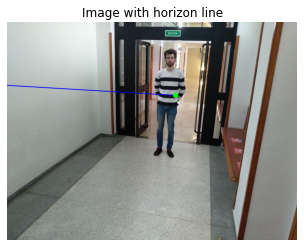

In [89]:
v1_xO = convert(coordinates = v1_x, img = im, code=2)
v2_yO = convert(coordinates = v2_y, img = im, code=2)

im_L = cv2.line(im, v1_xO, v2_yO, (255,0,0), 9)
im_L = cv2.circle(im_L, tuple(v1_xO), 35, (0,255,0), -1) #fuera de la imagen
im_L = cv2.circle(im_L, tuple(v2_yO), 35, (0,255,0), -1)
im_L = cv2.cvtColor (im_L, cv2.COLOR_RGB2BGR)

plt.figure()
plt.title('Image with horizon line')
plt.imshow(im_L)
plt.axis('off')

#### Cálculo de $\alpha$

Una vez ya tenemos la linea de horizonte (definida como un vector 3D en el espacio proyectivo), estamos en disposición de despejar $\alpha$ en nuestra ecuación. 

In [90]:
cross_bi_ti = np.cross(bi_H, ti_H)
num = np.linalg.norm(cross_bi_ti)

cross_vz_ti = np.cross(v3_z, ti_H)
den1 = np.linalg.norm(cross_vz_ti)
dot_L_bi = np.dot(L,bi_H)
den = dot_L_bi*den1*Zi

alpha = num/den
print(alpha)

7.189721062427415e-39


Una vez hallado $\alpha$, se definen los puntos extremos (inferior y superior) de la persona de la cual se quiere obtener su altura. Esto se realiza de la misma forma que en anteriores pasos. Una vez definidos, se transforman a coordenadas homogeneas.

In [91]:
bm = [2174.013, 1800.636]
tm = [2263.299, 412.649]

bm_H = convert(coordinates = bm, img = im, code=1)
tm_H = convert(coordinates = tm, img = im, code=1)

El resto de parámetros ya son sabidos (línea de horizonte y punto de fuga en el plano Z). Así pues, se procede a calcular su altura.

In [92]:
cross_bm_tm = np.cross(bm_H, tm_H)
num = np.linalg.norm(cross_bm_tm)

cross_vz_tm = np.cross(v3_z, tm_H)
den1 = np.linalg.norm(cross_vz_tm)
dot_L_bm = np.dot(L,bm_H)
den = dot_L_bm*den1*alpha

Zm = num/den
print('La altura de Miquel es:', Zm, 'cm')

La altura de Miquel es: 184.0295428462231 cm


#### Miquel mide 184 cm

## Segunda parte: altura propia

En esta segunda parte se propuso realizar el mismo proceso pero estimando la altura propia. Los pasos seguidos son exactamente los mismos que hasta ahora. 

In [93]:
im2 = cv2.imread ('./in/salon.jpeg')

(-0.5, 827.5, 1108.5, -0.5)

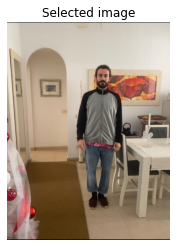

In [94]:
im2_BGR = cv2.cvtColor (im2, cv2.COLOR_RGB2BGR)

plt.figure()
plt.imshow(im2_BGR)
plt.title('Selected image')
plt.axis('off')

#### Selección de puntos

In [95]:
bi2 = [670.046, 1001.381]
ti2 = [692.550, 693.825]

Zi2 = 76 ##cm

p1_y2 = [635.54, 1095.9]
p2_y2 = [574.029, 965.374]

p3_y2 = [818.573, 1052.4]
p4_y2 = [740.559, 951.871]

p1_x2 = [433.004, 1028.386]
p2_x2 = [536.522, 1019.384]

p3_x2 = [399.0, 915.865]
p4_x2 = [620.537, 902.363]

p1_z2 = [309.981, 605.310]
p2_z2 = [305.481, 348.763]

p3_z2 = [114.946, 603.809]
p4_z2 = [98.443, 344.262]

#### Conversión a coordenadas homogéneas

In [96]:
bi_H2 = convert(coordinates = bi2, img = im2, code=1)
ti_H2 = convert(coordinates = ti2, img = im2, code=1)

p1_yH2 = convert(coordinates = p1_y2, img = im2, code=1)
p2_yH2 = convert(coordinates = p2_y2, img = im2, code=1)

p3_yH2 = convert(coordinates = p3_y2, img = im2, code=1)
p4_yH2 = convert(coordinates = p4_y2, img = im2, code=1)

p1_xH2 = convert(coordinates = p1_x2, img = im2, code=1)
p2_xH2 = convert(coordinates = p2_x2, img = im2, code=1)

p3_xH2 = convert(coordinates = p3_x2, img = im2, code=1)
p4_xH2 = convert(coordinates = p4_x2, img = im2, code=1)

p1_zH2 = convert(coordinates = p1_z2, img = im2, code=1)
p2_zH2 = convert(coordinates = p2_z2, img = im2, code=1)

p3_zH2 = convert(coordinates = p3_z2, img = im2, code=1)
p4_zH2 = convert(coordinates = p4_z2, img = im2, code=1)

#### Cálculo de los puntos de fuga

In [97]:
l1_x2 = np.cross (p1_xH2, p2_xH2)
l2_x2 = np.cross (p3_xH2, p4_xH2)

v1_x2 = np.cross (l1_x2, l2_x2)


l1_y2 = np.cross (p1_yH2, p2_yH2)
l2_y2 = np.cross (p3_yH2, p4_yH2)

v2_y2 = np.cross (l1_y2, l2_y2)


l1_z2 = np.cross (p1_zH2, p2_zH2)
l2_z2 = np.cross (p3_zH2, p4_zH2)

v3_z2 = np.cross (l1_z2, l2_z2)

#### Cálculo de la linea de horizonte

In [98]:
L2 = np.cross (v1_x2, v2_y2)

####  Visualizamos la linea de horizonte

(-0.5, 827.5, 1108.5, -0.5)

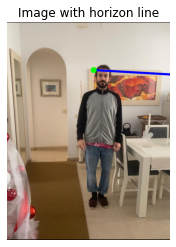

In [99]:
v1_xO2 = convert(coordinates = v1_x2, img = im2, code=2)
v2_yO2 = convert(coordinates = v2_y2, img = im2, code=2)

im_L2 = cv2.line(im2, v1_xO2, v2_yO2, (255,0,0), 9)
im_L2 = cv2.circle(im_L2, tuple(v1_xO2), 15, (0,255,0), -1) # fuera de la imagen
im_L2 = cv2.circle(im_L2, tuple(v2_yO2), 15, (0,255,0), -1)
im_L2 = cv2.cvtColor (im_L2, cv2.COLOR_RGB2BGR)

plt.figure()
plt.title('Image with horizon line')
plt.imshow(im_L2)
plt.axis('off')

#### Cálculo del parámetro $\alpha$

In [100]:
cross_bi_ti2 = np.cross(bi_H2, ti_H2)
num2 = np.linalg.norm(cross_bi_ti2)

cross_vz_ti2 = np.cross(v3_z2, ti_H2)
den12 = np.linalg.norm(cross_vz_ti2)
dot_L_bi2 = np.dot(L2,bi_H2)
den2 = dot_L_bi2*den12*Zi2

alpha2 = num2/den2
print(alpha2)

8.979162241707674e-31


#### Definición de mis puntos extremos

In [101]:
bm2 = [463.009, 902.363]
tm2 = [493.014, 231.742]

bm_H2 = convert(coordinates = bm2, img = im2, code=1)
tm_H2 = convert(coordinates = tm2, img = im2, code=1)

#### Estimación de mi altura en cm

In [102]:
cross_bm_tm2 = np.cross(bm_H2, tm_H2)
num2 = np.linalg.norm(cross_bm_tm2)

cross_vz_tm2 = np.cross(v3_z2, tm_H2)
den12 = np.linalg.norm(cross_vz_tm2)
dot_L_bm2 = np.dot(L2,bm_H2)
den2 = dot_L_bm2*den12*alpha2

Zm2 = num2/den2
print('Mi altura es:',Zm2,'cm')

Mi altura es: 174.46939147640188 cm


#### Según el código yo mido 174.5 cm. A continuación se muestra una foto con un metro y mi altura real. 

(-0.5, 2459.5, 2858.5, -0.5)

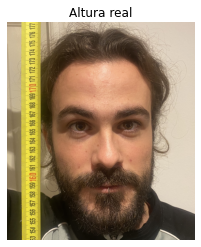

In [103]:
altura = cv2.imread('./in/altura.jpg')
altura = cv2.cvtColor (altura, cv2.COLOR_RGB2BGR)

plt.figure
plt.imshow(altura)
plt.title('Altura real')
plt.axis('off')

#### Aunque no se aprecian con total claridad los números de la cinta, mi altura real es 175 cm

## Epipolar lines

En esta segunda parte de la práctica se trabaja con la visión estéreo. La visión estéreo se utiliza principalmente para poder trabajar con la profundidad de los puntos, ya que si solo dispones de una sola imagen de la escena la información relativa a la profundidad de los puntos se pierde. En la imagen siguiente puede verse la idea de este tipo de sistemas. 
![Visión estéreo](./in/epipolar.jpg)

Si solo se tuviese la imagen de la derecha sería imposible calcular la profundidad del punto X. Sin embargo, gracias a la incorporación de una segunda cámara puede triangularse la posición del punto en 3D. 

En concreto, en este segundo ejercicio nos centraremos en las epilíneas o lineas epipolares. En la imagen de arriba puede observarse como la proyección de la recta $OX$ forma una linea en la imagen de la derecha (linea $l'$). Esta línea de conoce como la epilínea del punto $x$. Esto significa que para encontrar el punto $x$ de la imagen izquierda en la imagen derecha se debe buscar en la epilínea. Esto es lo que se conoce como restricción epipolar y reduce el problema de correspondencia entre puntos a un problema 1D si se conoce la epilínea. 

Para esto último se debe determinar la Matriz Fundamentental. Una vez calculada, se establece la siguiente relación: 

$l' = Fx$

Donde $l'$ es la epilínea en la imagen derecha, F es la Matriz Fundamental y x es el punto en la imagen izquierda. También puede describirse de forma inversa como: 

$l = F^Tx'$

Por otro lado,el plano $XOO'$ se conoce como plano epipolar. Los puntos de intersección de la recta $OO'$ (centros proyectivos) con los planos de la imagen formas los que se conoce como epipolos. Todas las líneas epipolares de una imagen intersectan en el epipolo. 

Primero se definen aquellas funciones que van a permitir encontrar correspondencias entre puntos en las dos imágenes. Son las mismas funciones que se emplearon en la práctica 2. 

In [104]:
def get_kp_desc(method: str, img: np.ndarray, **kwargs):

    method_call = None

    if method == "O":
        orb = cv2.ORB_create(**kwargs)
        method_call = orb.detectAndCompute
    elif method == "sift":
        sift = cv2.xfeatures2d.SIFT_create(**kwargs)
        method_call = sift.detectAndCompute
    elif method == "fast_brief":
        fast = cv2.FastFeatureDetector_create() # Create FAST object with default values
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create() #Creating BRIEF object with default values
        kp = fast.detect(img, None)
        kp, descs = brief.compute(img, kp)
        return kp, descs
    elif method == "surf":
        surf = cv2.xfeatures2d.SURF_create(400) #threshold of the Hessian determinant. Value found in web
        method_call = surf.detectAndCompute


    kp, descs = method_call(img, mask=None, **kwargs) #SIFT, ORB y SURF

    return kp, descs

In [105]:
def match_descriptors(method: str, desc1, desc2, **kwargs):
    
    matches = None
    if method == "D":
        matcher = cv2.DescriptorMatcher_create(
            cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
        matches = matcher.match(desc1, desc2) #, **kwargs)
    elif method == "F":
        matcher = cv2.BFMatcher()
        matches = matcher.knnMatch(desc1, desc2, **kwargs)

    return matches

In [106]:
def filter_matches(method: str, matches, min_distance: int = None,
                   proportion: float = None):
    
    if method == "DIST":
        matches = list(filter(lambda m: m.distance < min_distance, matches))
    elif method == "KNN":
        matches = list(
            filter(lambda m: m[0].distance < m[1].distance * proportion,
                   matches))

    return matches

A continaución se define una función que permite dibujar las lineas epipolares calculadas sobre la imagen además de los puntos correspondientes. 

Las lineas encontradas toman el formato de un vector con tres escalares de la forma $(a,b,c)$, donde cada ecalarar es un coeficiente de la ecuación de la recta $ax + by +c = 0$. Para conseguir representar dicha recta con la función _line_ de OpcenCV se calcula el intercepto de la recta y el punto intersección de dicha recta con el final del plano imagen.  

In [107]:
def draw_epipolar_lines(img1: np.ndarray, img2: np.ndarray, lines, pts1, pts2):

    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])

        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)

    return img1, img2

In [108]:
left_im = cv2.imread('./in/left.jpg',0)
right_im = cv2.imread('./in/right.jpg',0)

Como ya se ha comentado, lo primero es encontrar correspondencias de puntos entre ambas imágenes. Esto es necesario para posteriormente calcular la Matriz Fundamental. 

Para esta tarea se va a emplear el método SIFT expuesto en la anterior práctica. 

In [109]:
kp1, desc1 = get_kp_desc(method="sift", img=left_im)
kp2, desc2 = get_kp_desc(method="sift", img=right_im)

Una vez halladaos los _keypoints_ y descriptores se calculan los matches entre imágenes.

In [110]:
matches = match_descriptors(method="F", desc1=desc1,
                                        desc2=desc2, k=2)

Posteriormente se procede a seleccionar los mejores matches. Cabe destacar que ha sido necesario aumentar el umbral para el filtrado de matches con tal de que el cálculo de la Matriz Fundamental sea correcto. 

Esto último es así ya que seleccionar los mejores _matches_ no significa seleccionar las mejores correspondencias de puntos en la práctica. El fitlrado de _matches_ se realiza en términos de distancia, lo que equivale a cuánto de parecidos son los descriptores de los puntos clave en cuestión. Que dos descriptores sean muy semejantes no significa que los puntos clave correspondan al mismo punto en la realidad. Esto puede observarse en las letras de las portadas de los libros, donde es muy fácil que existan descriptores parecidos pero correspondientes a puntos distintos en la realidad. 

Es por ello que si se mantiene un umbral bajo, seleccionando únicamente aquellos _matches_ teóricamente correctos pero que después en la práctica se ha comprobado que no todos corresponden con los mismos puntos, el algoritmo de OpenCV para calcular la matriz es sensible a estos fallos y opera correctamente. Así pues, aumentando el número de _matches_ para el cálculo de la matriz se "mitiga" el efecto que estas correspondencias erróneas tienen sobre el cálculo de la matriz. 

In [111]:
matches = filter_matches(method="KNN", matches=matches,
                                     proportion=0.95)

In [112]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

Se guardan los puntos correspondientes a los _matches_ encontrados. 

In [113]:
for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt

Se calcula la Matriz Fundamental. Para ello se emplea de nuevo el algoritmo RANSAC, el cual ya fué brevemente explicado en la prática anterior pero que básicamente permite un cálculo de la Matriz Fundamental más robusto antes correspondencias erróneas. 

In [114]:
F, mask = cv2.findFundamentalMat(points1,points2,cv2.FM_RANSAC)

La función anterior devuelve un vector columna binario _mask_ que permite identificar qué puntos entre los seleccionados mantienen una correspondencia adecuada. 

In [115]:
# Only inliers points

points1 = points1[mask.ravel()==1]
points2 = points2[mask.ravel()==1]

Se calculan las lineas epipolares en cada una de las imágenes

In [116]:
line1 = cv2.computeCorrespondEpilines(points2, 2, F)
line2 = cv2.computeCorrespondEpilines(points1, 1, F)

line1 = line1.reshape(-1,3)
line2 = line2.reshape(-1,3)

Se dibujan las lineas epipolares

In [117]:
left_line, right_points = draw_epipolar_lines(img1 = left_im, img2 = right_im, lines = line1, pts1 = points1, pts2 = points2)
right_line, left_points = draw_epipolar_lines(img1 = right_im, img2 = left_im, lines = line2, pts1 = points2, pts2 = points1)

(-0.5, 611.5, 458.5, -0.5)

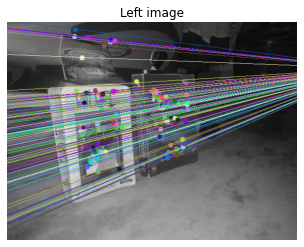

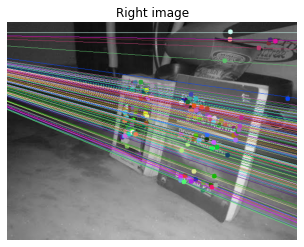

In [118]:
plt.figure(1)
plt.imshow(left_line)
plt.title('Left image')
plt.axis('off')

plt.figure(2)
plt.imshow(right_line)
plt.title('Right image')
plt.axis('off')

### Segunda parte: imágenes propias

En esta segunda parte se realiza exactamente el mismo procedimiento que en la primera parte pero con imágenes propias. 

In [119]:
left_sce = cv2.imread('./in/escena1.jpeg',0)
right_sce = cv2.imread('./in/escena2.jpeg',0)

In [120]:
kp1_sce, desc1_sce = get_kp_desc(method="sift", img=left_sce)
kp2_sce, desc2_sce = get_kp_desc(method="sift", img=right_sce)

In [121]:
matches_sce = match_descriptors(method="F", desc1=desc1_sce,
                                        desc2=desc2_sce, k=2)

In [122]:
matches_sce = filter_matches(method="KNN", matches=matches_sce,
                                     proportion=0.7)

In [123]:
points1_sce = np.zeros((len(matches_sce), 2), dtype=np.float32)
points2_sce = np.zeros((len(matches_sce), 2), dtype=np.float32)

for i, match in enumerate(matches_sce):
    points1_sce[i, :] = kp1_sce[match[0].queryIdx].pt
    points2_sce[i, :] = kp2_sce[match[0].trainIdx].pt

In [124]:
F_sce, mask_sce = cv2.findFundamentalMat(points1_sce,points2_sce,cv2.FM_RANSAC)

In [125]:
points1_sce = points1_sce[mask_sce.ravel()==1]
points2_sce = points2_sce[mask_sce.ravel()==1]

In [126]:
line1_sce = cv2.computeCorrespondEpilines(points2_sce, 2, F_sce)
line2_sce = cv2.computeCorrespondEpilines(points1_sce, 1, F_sce)

line1_sce = line1_sce.reshape(-1,3)
line2_sce = line2_sce.reshape(-1,3)

In [127]:
left_line_sce, right_points_sce = draw_epipolar_lines(img1 = left_sce, img2 = right_sce, lines = line1_sce, pts1 = points1_sce, pts2 = points2_sce)
right_line_sce, left_points_sce = draw_epipolar_lines(img1 = right_sce, img2 = left_sce, lines = line2_sce, pts1 = points2_sce, pts2 = points1_sce)

(-0.5, 1199.5, 1599.5, -0.5)

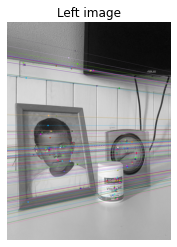

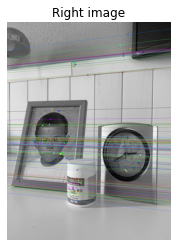

In [128]:
plt.figure(3)
plt.imshow(left_line_sce)
plt.title('Left image')
plt.axis('off')

plt.figure(4)
plt.imshow(right_line_sce)
plt.title('Right image')
plt.axis('off')